# Alpha Band Investigation
This notebook is solely written to test if alpha bands varied in Resting State data gathered from HBN 10th Release.

In [12]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy import signal as sg

In [13]:
# load single fif file

# load processed fif file
processed_dir = os.path.join('..', '..', 'processed')
resting_files = glob.glob(os.path.join(processed_dir, "*resting_state*.fif"))

raw = mne.io.read_raw_fif(resting_files[20], preload=True)

Opening raw data file ..\..\processed\resting_state_cleaned_27.fif...
    Range : 0 ... 182981 =      0.000 ...   365.962 secs
Ready.
    Range : 0 ... 182981 =      0.000 ...   365.962 secs
Ready.
Reading 0 ... 182981  =      0.000 ...   365.962 secs...
Reading 0 ... 182981  =      0.000 ...   365.962 secs...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_24332\1207279124.py:7: RuntimeWarning: This filename (..\..\processed\resting_state_cleaned_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(resting_files[20], preload=True)


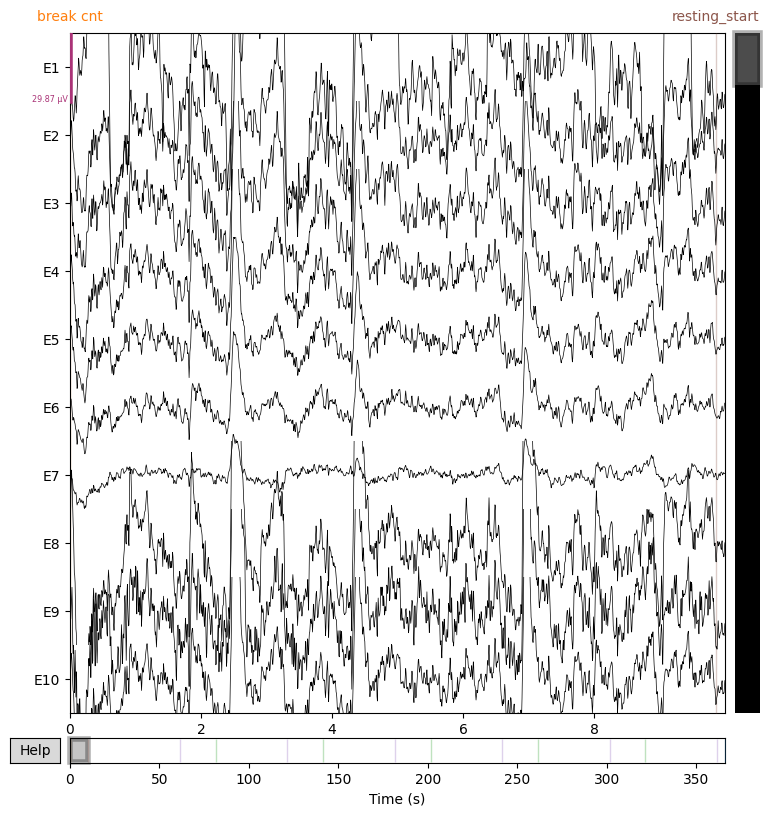

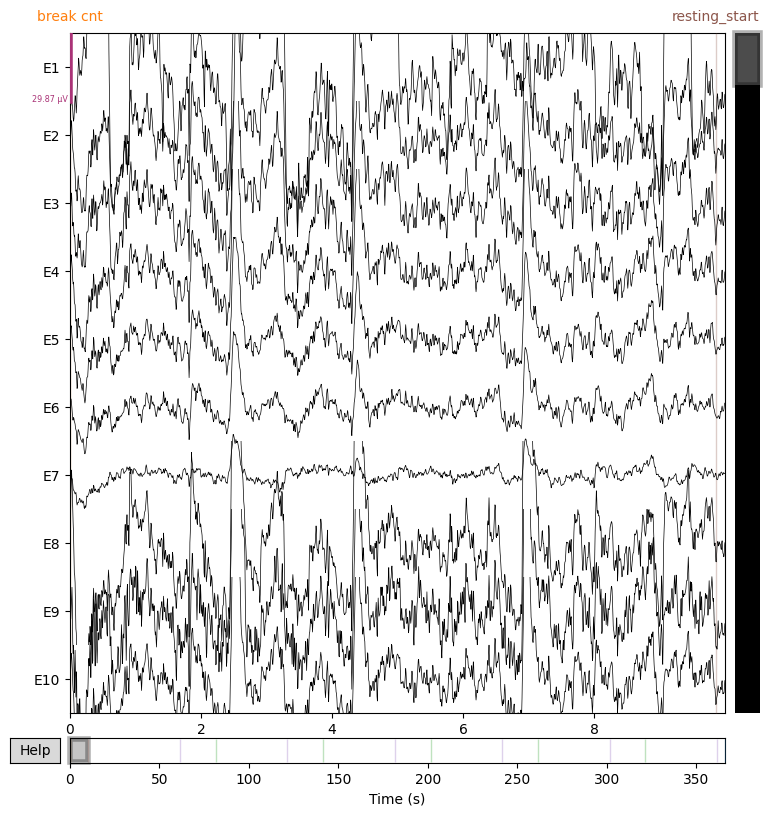

In [14]:
raw.plot(duration=10, n_channels=10, scalings='auto', title='Raw EEG Data')


In [15]:
events, event_dict = mne.events_from_annotations(raw)

# get event IDs for close and open eyes conditions
close_eyes_id = event_dict.get('instructed_toCloseEyes')
open_eyes_id = event_dict.get('instructed_toOpenEyes')

# filter events by event ID (third column)
close_eyes = events[events[:, 2] == close_eyes_id] if close_eyes_id else np.array([])
open_eyes = events[events[:, 2] == open_eyes_id] if open_eyes_id else np.array([])

Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']


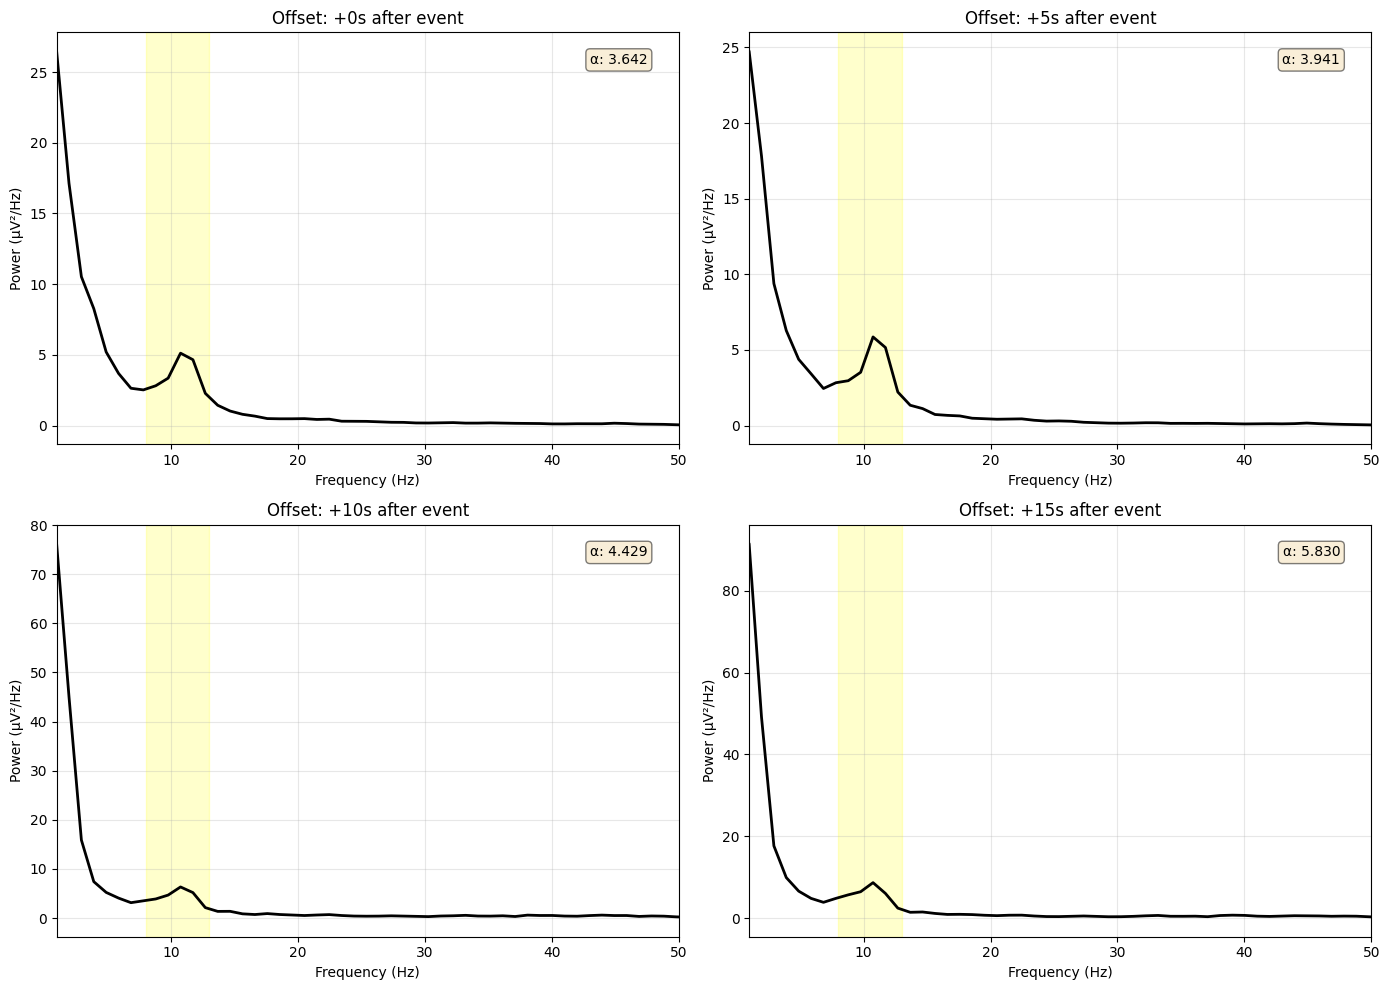

In [16]:
# validate that there is difference between open and closed PSDs
sfreq = raw.info['sfreq']

offsets = [0, 5, 10, 15]
duration = 20

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, offset in enumerate(offsets):
    start_sample = close_eyes[0, 0] + int(offset * sfreq)
    n_samples = int(duration * sfreq)
    
    # Check if we have enough data
    if start_sample + n_samples > raw.n_times:
        axes[idx].text(0.5, 0.5, 'Not enough data', ha='center', va='center')
        axes[idx].set_title(f'Offset: +{offset}s (NO DATA)')
        continue
    
    data_segment = raw.get_data(start=start_sample, stop=start_sample + n_samples)
    
    # Average PSD across posterior channels
    n_ch = data_segment.shape[0]
    posterior_chs = range(int(n_ch * 0.8), n_ch)
    
    psd_avg = []
    for ch in posterior_chs:
        f, Pxx = sg.welch(data_segment[ch], fs=sfreq, nperseg=512)
        psd_avg.append(Pxx)
    
    psd_mean = np.mean(psd_avg, axis=0)
    
    axes[idx].plot(f, psd_mean * 1e12, 'k-', linewidth=2)
    axes[idx].axvspan(8, 13, alpha=0.2, color='yellow')
    axes[idx].set_title(f'Offset: +{offset}s after event')
    axes[idx].set_xlabel('Frequency (Hz)')
    axes[idx].set_ylabel('Power (µV²/Hz)')
    axes[idx].set_xlim(1, 50)
    axes[idx].grid(True, alpha=0.3)
    
    # Calculate alpha power
    alpha_mask = (f >= 8) & (f <= 13)
    alpha_power = np.mean(psd_mean[alpha_mask]) * 1e12
    axes[idx].text(0.95, 0.95, f'α: {alpha_power:.3f}', 
                   transform=axes[idx].transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

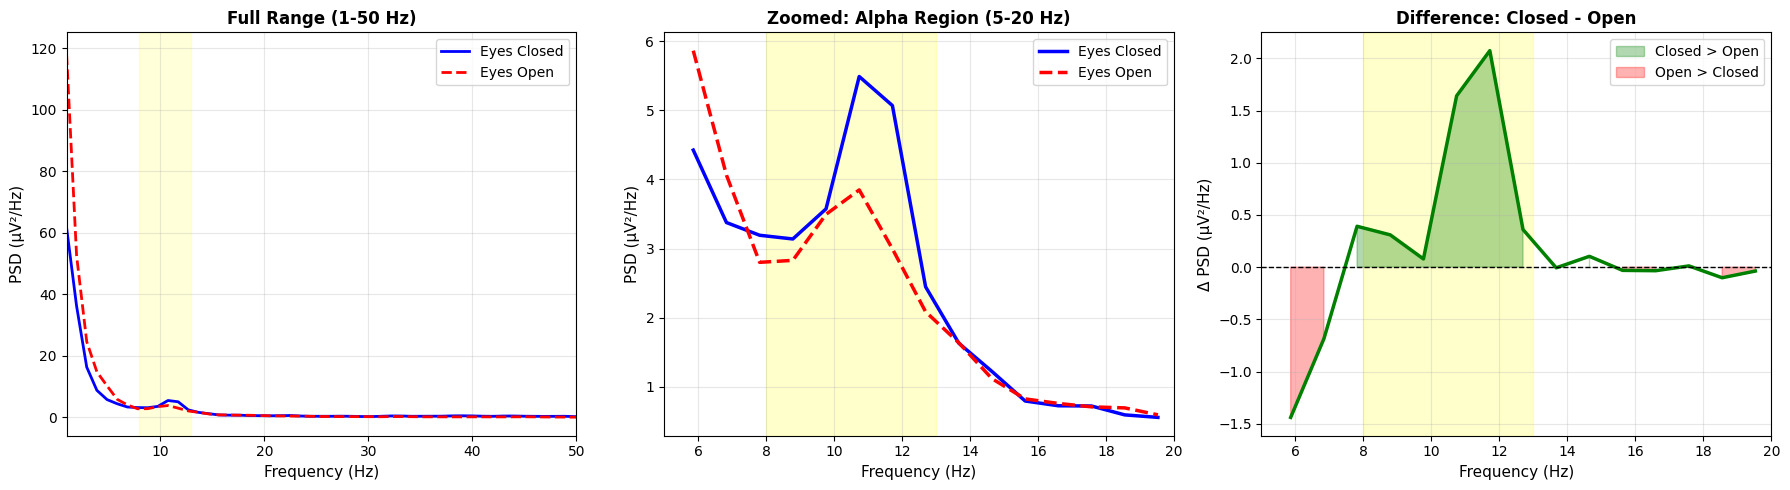

In [17]:
# zoom into alpha bands (generated by copilot)

offset = 0
duration = 30
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

start_closed = close_eyes[0, 0] + int(offset * sfreq)
start_open = open_eyes[0, 0] + int(offset * sfreq)

data_closed = raw.get_data(start=start_closed, stop=start_closed + n_samples)
data_open = raw.get_data(start=start_open, stop=start_open + n_samples)

n_ch = data_closed.shape[0]
posterior_chs = range(int(n_ch * 0.8), n_ch)

psd_closed_all = []
psd_open_all = []

for ch in posterior_chs:
    f_c, P_c = sg.welch(data_closed[ch], fs=sfreq, nperseg=512)
    f_o, P_o = sg.welch(data_open[ch], fs=sfreq, nperseg=512)
    psd_closed_all.append(P_c)
    psd_open_all.append(P_o)

psd_closed_mean = np.mean(psd_closed_all, axis=0) * 1e12
psd_open_mean = np.mean(psd_open_all, axis=0) * 1e12

# Create 3-panel figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Full range, linear
axes[0].plot(f_c, psd_closed_mean, 'b-', linewidth=2, label='Eyes Closed')
axes[0].plot(f_o, psd_open_mean, 'r--', linewidth=2, label='Eyes Open')
axes[0].axvspan(8, 13, alpha=0.15, color='yellow', zorder=0)
axes[0].set_xlabel('Frequency (Hz)', fontsize=11)
axes[0].set_ylabel('PSD (µV²/Hz)', fontsize=11)
axes[0].set_title('Full Range (1-50 Hz)', fontsize=12, fontweight='bold')
axes[0].set_xlim(1, 50)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: Zoomed to alpha band (5-20 Hz), linear
mask = (f_c >= 5) & (f_c <= 20)
axes[1].plot(f_c[mask], psd_closed_mean[mask], 'b-', linewidth=2.5, label='Eyes Closed')
axes[1].plot(f_o[mask], psd_open_mean[mask], 'r--', linewidth=2.5, label='Eyes Open')
axes[1].axvspan(8, 13, alpha=0.2, color='yellow', zorder=0)
axes[1].set_xlabel('Frequency (Hz)', fontsize=11)
axes[1].set_ylabel('PSD (µV²/Hz)', fontsize=11)
axes[1].set_title('Zoomed: Alpha Region (5-20 Hz)', fontsize=12, fontweight='bold')
axes[1].set_xlim(5, 20)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Panel 3: Difference plot (Closed - Open)
diff = psd_closed_mean - psd_open_mean
axes[2].plot(f_c[mask], diff[mask], 'g-', linewidth=2.5)
axes[2].axhline(0, color='k', linestyle='--', linewidth=1)
axes[2].axvspan(8, 13, alpha=0.2, color='yellow', zorder=0)
axes[2].fill_between(f_c[mask], 0, diff[mask], where=(diff[mask] > 0), 
                      color='green', alpha=0.3, label='Closed > Open')
axes[2].fill_between(f_c[mask], 0, diff[mask], where=(diff[mask] < 0), 
                      color='red', alpha=0.3, label='Open > Closed')
axes[2].set_xlabel('Frequency (Hz)', fontsize=11)
axes[2].set_ylabel('Δ PSD (µV²/Hz)', fontsize=11)
axes[2].set_title('Difference: Closed - Open', fontsize=12, fontweight='bold')
axes[2].set_xlim(5, 20)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
alpha_mask = (f_c >= 8) & (f_c <= 13)
peak_diff = np.max(diff[alpha_mask])
peak_freq = f_c[alpha_mask][np.argmax(diff[alpha_mask])]

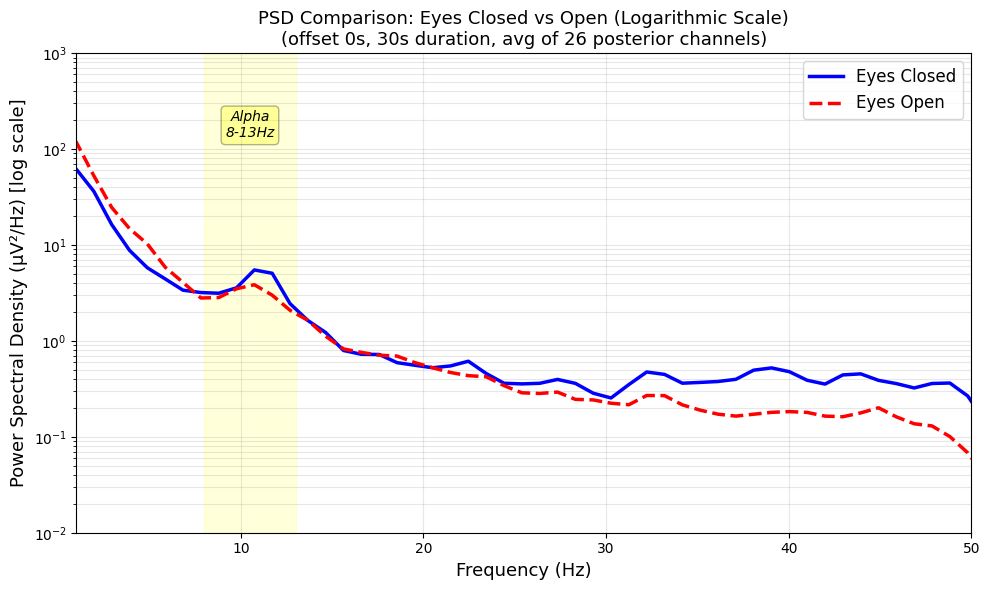

In [18]:
# logarithmic scale comparison (semilogy) (generated by copilot)

offset = 0
duration = 30
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

start_closed = close_eyes[0, 0] + int(offset * sfreq)
start_open = open_eyes[0, 0] + int(offset * sfreq)

data_closed = raw.get_data(start=start_closed, stop=start_closed + n_samples)
data_open = raw.get_data(start=start_open, stop=start_open + n_samples)

n_ch = data_closed.shape[0]
posterior_chs = range(int(n_ch * 0.8), n_ch)

psd_closed_all = []
psd_open_all = []

for ch in posterior_chs:
    f_c, P_c = sg.welch(data_closed[ch], fs=sfreq, nperseg=512)
    f_o, P_o = sg.welch(data_open[ch], fs=sfreq, nperseg=512)
    psd_closed_all.append(P_c)
    psd_open_all.append(P_o)

psd_closed_mean = np.mean(psd_closed_all, axis=0) * 1e12
psd_open_mean = np.mean(psd_open_all, axis=0) * 1e12

# Create figure with logarithmic y-axis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot with semilogy (log scale y-axis)
ax.semilogy(f_c, psd_closed_mean, 'b-', linewidth=2.5, label='Eyes Closed')
ax.semilogy(f_o, psd_open_mean, 'r--', linewidth=2.5, label='Eyes Open')

# Highlight alpha band
ax.axvspan(8, 13, alpha=0.15, color='yellow', zorder=0)
ax.text(10.5, ax.get_ylim()[1]*0.3, 'Alpha\n8-13Hz', 
        ha='center', va='center', fontsize=10, style='italic',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

ax.set_xlabel('Frequency (Hz)', fontsize=13)
ax.set_ylabel('Power Spectral Density (µV²/Hz) [log scale]', fontsize=13)
ax.set_title(f'PSD Comparison: Eyes Closed vs Open (Logarithmic Scale)\n(offset {offset}s, {duration}s duration, avg of {len(posterior_chs)} posterior channels)', 
             fontsize=13)
ax.set_xlim(1, 50)
ax.set_ylim(0.01, 1000)  # Set reasonable limits for log scale
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Calculate alpha power statistics
alpha_mask = (f_c >= 8) & (f_c <= 13)
alpha_closed = np.mean(psd_closed_mean[alpha_mask])
alpha_open = np.mean(psd_open_mean[alpha_mask])
ratio = alpha_closed / alpha_open if alpha_open > 0 else 0